# Paddy competition

We will get started with [Paddy](https://www.kaggle.com/competitions/paddy-disease-classification) competition from Kaggle.

Last blog, we went over how to setup kaggle API and download data. We will use data from last time and create a submission. At this point, our goal is not to get to the top of the submissions, but to create a baseline. We just want our model to train reasonably well, so that we can make improvements on it later. 

We first 

In [1]:
from fastai.vision.all import *

In [2]:
path = Path()
path.ls()

(#33) [Path('subm_res18_45ep_tta.csv'),Path('11_blog_base-Copy1.ipynb'),Path('README.md'),Path('subm_res18_15ep_tta.csv'),Path('11_blog_base.ipynb'),Path('subm_res18_10ep_tta.csv'),Path('sample_submission.csv'),Path('subm_res18_40ep_tta.csv'),Path('subm_res18_35ep_tta.csv'),Path('subm_res18_5ep_tta.csv')...]

## Explore data

Before we do anything, we can look at the data to find out how they are structured. It's helpful to read [data](https://www.kaggle.com/competitions/paddy-disease-classification/data) section of the competition as well. 

In [3]:
trn_path = path/'train_images'
trn_path.ls()

(#12) [Path('train_images/res34_12.pkl'),Path('train_images/bacterial_panicle_blight'),Path('train_images/dead_heart'),Path('train_images/tungro'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/bacterial_leaf_streak'),Path('train_images/brown_spot'),Path('train_images/bacterial_leaf_blight'),Path('train_images/downy_mildew')...]

Using `get_image_files`, we can get all the image files in the directory recursively.

In [4]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_panicle_blight/109162.jpg'),Path('train_images/bacterial_panicle_blight/109183.jpg'),Path('train_images/bacterial_panicle_blight/101765.jpg'),Path('train_images/bacterial_panicle_blight/101592.jpg'),Path('train_images/bacterial_panicle_blight/104770.jpg'),Path('train_images/bacterial_panicle_blight/110190.jpg'),Path('train_images/bacterial_panicle_blight/106643.jpg'),Path('train_images/bacterial_panicle_blight/104269.jpg'),Path('train_images/bacterial_panicle_blight/108023.jpg'),Path('train_images/bacterial_panicle_blight/107676.jpg')...]

In [5]:
pd.read_csv('train.csv').head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


We can see that image labels are divided by folders. 

Let's now look at an image and its size. It is (192, 256). We can check sizes of others as well.

(192, 256)


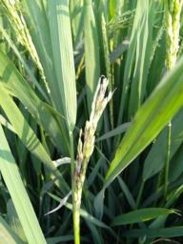

In [6]:
im = PILImage.create(files[0])
print(im.size)
im.to_thumb(244)

We can check sizes of all the images fast using parallel. It has some restrictions, but it makes it faster. However, it is not guaranteed to be fast as overhead can be from Input/Output of files. For instance, in paperspace instance, it took almost the same amount of time whether I used parallel or not because my files were in cloud. So, it was taking a long time due to internet, not CPU.

In [7]:
from fastcore.parallel import *

def get_img_size(path):
    return PILImage.create(path).size

sizes = parallel(get_img_size, files)
sizes

(#10407) [(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256),(192, 256)...]

In [8]:
sizes = pd.Series(sizes)
sizes.value_counts()

(192, 256)    10403
(256, 192)        4
dtype: int64

Except for 4 images, everything had the same sizes. 

## Create dataloaders

Now, we can create an Image Dataloaders from the folders. It is very easy with fastai. We only have to provide path to look for data, how to split validation and train data, and how to transfor images. fastai figures out everything else for us, such as how to process images and labels and creating batches.

In [9]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(size=(244)),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)

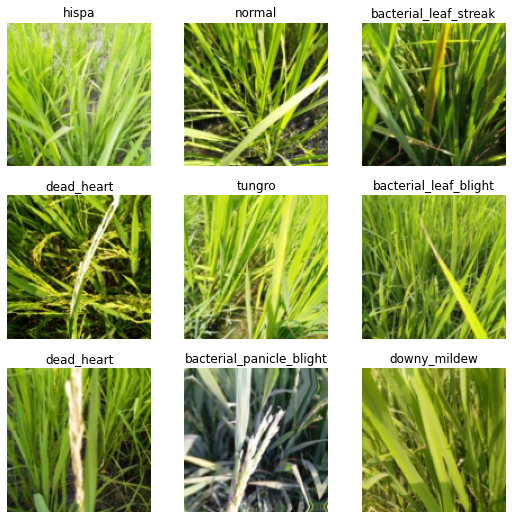

In [10]:
dls.show_batch()

It's very important to look at images here and see whether they are labeled correctly. If these are not correctly labelled, we have to go back and fix path or whatever that was wrong. If it is wrong, even if we train it, it won't give us good results. 

One problem is that I don't know anything about plant disease. I can google it to learn about them, but it will take some time. So, I decided to just go ahead and train.

## Learner

We are using resnet34, which is not a great one, but it's good enough to figure out whether we are doing good, and it's fairly fast. We just want to get a model that works fast at this point.

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For most problems, we can use learning rates from 0.008 to 0.01. But is that really the case? We can find out the learning rate to be sure.

SuggestedLRs(valley=0.001737800776027143)

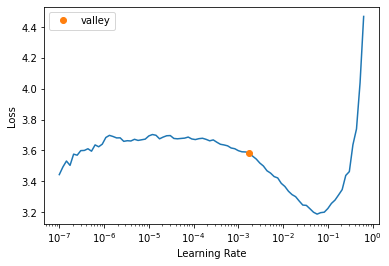

In [12]:
learn.lr_find()

I will use 0.008 to be safe as 0.01 looks like it's on the very bottom.

In [13]:
learn.fine_tune(12, base_lr=0.008)

epoch,train_loss,valid_loss,error_rate,time
0,2.089899,1.361343,0.447862,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.948025,0.553810,0.174916,00:43
1,0.672299,0.479599,0.160500,00:44
2,0.579641,0.530578,0.172033,00:43
3,0.523039,0.450268,0.136953,00:43
4,0.459746,0.452649,0.124459,00:43
5,0.375885,0.333700,0.098030,00:43
6,0.261719,0.249268,0.072561,00:44
7,0.197946,0.174411,0.053340,00:43
8,0.142218,0.145764,0.042768,00:43
9,0.092104,0.118818,0.032196,00:43


We use fine_tune to train because we are using transfer learning. This means that we are using pre-trained model, such as resnet34, instead of creating a model from scratch. This saves us a lot of time because those pre-trained models can recognize some features arleady. 

We can think about why this is true by thinking about playing a dodge ball game. Let's say there are some players who played many sports, such as basketball, baseball, and others, and others who never played anything at all. Who will most likely play better? Those who played sports will. Same thing here. resnet34 is already good at recognizing images, so why would we create a new model from scratch? 

However, rules for dodgeball is different from other sports. But we want to be good at dodgeball, so that's where fastai's fine_tune comes in. It basically "forgets" all the rules specific to other sports and "learns" new dodgeball rules! This concept is very important for deep learning, so we may comeback to this later. To learn about how it's done in code, we can look at the documentation and source code.

In [14]:
doc(learn.fine_tune)

Another place to learn more about transfer learning is [fastbook chapter 5](https://colab.research.google.com/github/fastai/fastbook/blob/master/05_pet_breeds.ipynb).

Since we are done with training, we can create a pickled file. It's basically saving our learner so that we can make predictions with this later without training it again. 

In [15]:
learn.export('res34_12.pkl')

## Inference

To create a submission, we have to create a csv file with correct labels based on image_ids. Here's a sample.

In [16]:
ss = pd.read_csv('sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


This is where test images come in. We have to sort this to match the order with image_ids.

In [17]:
test_path = get_image_files(path/'test_images').sorted()
test_path

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

We then add it to our dataloader's test_dl.

In [18]:
test_dl = dls.test_dl(test_path)
test_dl

With a learner, we can make predictions like this. Using `with_decoded=True`, we can optionally get indexes of the predictions. However, we need actual labels in the submission csv file instead of indexes. So we have to convert the indexes into labels.

In [19]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [20]:
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

To check the labels, we can look at it like this:

In [21]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

One way to convert indexes into labels is using pandas Series. So, we turn the indexes into padas Series.

In [22]:
idxs = pd.Series(idxs)
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Length: 3469, dtype: int64

We need to create mappings with indexes and labels. Then, we use the mappings to convert indexes into labels.

In [23]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [24]:
results = idxs.map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Length: 3469, dtype: object

Then, we can put the labels into our submissions.

In [25]:
ss.label = results
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [26]:
ss.to_csv('subm.csv', index=False)

In [27]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


Looks good. We can submit it by typing `kaggle competitions submit -f subm.csv -m 'init resnet34 12 epoch ft' padd-disease-classification`. `-f subm.csv` specifies the submission file and `-m 'init resnet34 12 epoch ft'` adds a message to the submission. It means initial submission using resnet34 with 12 epochs of training using fine tune. But you can put any message you want here. 

On [Paddy competition submissions](https://www.kaggle.com/competitions/paddy-disease-classification/submissions), you can check your score. Then, head over to leaderboard. For the first model, it's not bad.

## Conclusion

We went over how to train and create a submission to a kaggle competetition. Now that we have a baseline, we can start improving our model. Thanks to this baseline, we can figure out whether new strategies are working or not later. 

Helpful resources:
- [Live coding 7](https://www.youtube.com/watch?v=cagqUrHMDJ0&list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&index=7&ab_channel=JeremyHoward): Live coding video by Jeremy Howard. First time going over paddy competition.
- [Live coding 8](https://www.youtube.com/watch?v=-Scs4gbwWXg&list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&index=8&ab_channel=JeremyHoward): Live coding video by Jeremy Howard. 
- [fastai course](https://course.fast.ai/): Course covering basics to advanced deep learning.
- [Python for data analysis](https://wesmckinney.com/book/): A book covering tools for python data analysis. Mostly covering Pandas, but it also covers numpy and matplotlib.